In [0]:
from __future__ import division
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip
cwd = os.getcwd()

# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'        

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1433600/45929032 bytes (3.1%)4136960/45929032 bytes (9.0%)7929856/45929032 bytes (17.3%)11935744/45929032 bytes (26.0%)15876096/45929032 bytes (34.6%)19816448/45929032 bytes (43.1%)23633920/45929032 bytes (51.5%)27418624/45929032 bytes (59.7%)31268864/45929032 bytes (68.1%)35274752/45929032 bytes (76.8%)39329792/45929032 bytes (85.6%)43425792/45929032 bytes (94.5%)4

In [0]:
import imutils

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%cd '/content/gdrive/My Drive/computer vision project'
!ls

/content/gdrive/My Drive/computer vision project
frame3585.png	    parking_map_with_id_final.pickle  savedframe.png
frame3595.png	    parking_map_with_id.pickle	      Use_this.PNG
p1.PNG		    ps1.png			      with_parking.jpg
p2.PNG		    ps2.PNG
parking_map.pickle  ps3.png


In [0]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(15, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [0]:
image2 = np.array( imutils.resize(cv2.imread('frame3595.png'), width=1188) )

# image1, image2 = np.rot90(image1, 3), np.rot90(image2, 3)

In [0]:
#image1 = np.rot90(image1, 3)

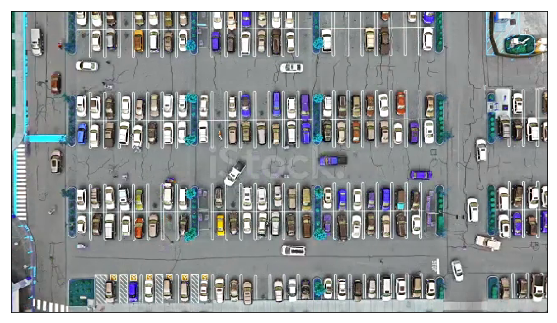

In [0]:
test_images = [np.array(image2)]
show_images(test_images)

### Color Selection and Edge Detection

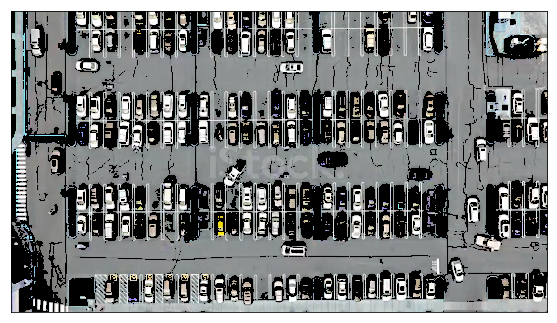

In [0]:
# image is expected be in RGB color space# image 
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([120, 120, 120])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

white_yellow_images = list(map(select_rgb_white_yellow, test_images))
show_images(white_yellow_images)

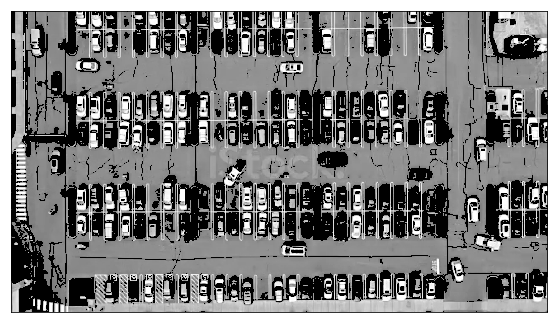

In [0]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

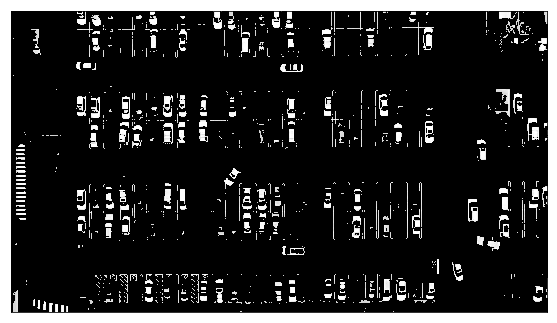

In [0]:
def remove_cracks(image):
    rows, cols = image.shape
    # black_color = np.array([0,0,0], dtype= image.dtype)
    pavement_color = 167   
    for i in range(rows):
        for j in range(cols):
            if image[i,j] <= 209:
                image[i,j] = 0
                # trrr = 1
    return image
 
no_crack = list(map(remove_cracks, list(gray_images)))
show_images(no_crack)

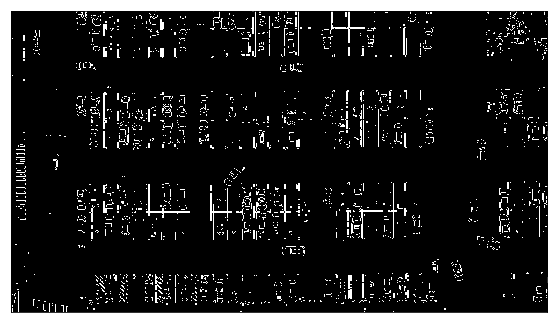

In [0]:
def detect_edges(image, low_threshold=100, high_threshold=200):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), no_crack))

show_images(edge_images)

### Identify area of interest

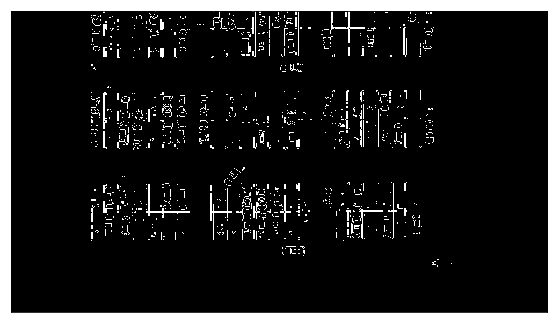

In [0]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    ratio_cols = 0.82
    ratio_rows = 0.85
    pt_1  = [cols*0.15, 0]
    pt_2 = [cols * ratio_cols, 0]
    pt_3 = [cols * ratio_cols, rows * ratio_rows]
    pt_4 = [cols*0.15, rows * ratio_rows]

    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[pt_1, pt_2, pt_3, pt_4]], dtype=np.int32)
    return filter_region(image, vertices)

# (651, 1188)
# images showing the region of interest onlyno_crack
# roi_images = list(map(select_region, edge_images))
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

### Hough line transform

In [0]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=0.1, theta=np.pi/10, threshold=15, minLineLength=9, maxLineGap=4)


# list_of_lines = list(map(hough_lines, roi_images))
list_of_lines = list(map(hough_lines, roi_images))

('MAX WIDTH: ', 0)
(' No lines detected: ', 9)
(dtype('uint8'), (668, 1188, 3))


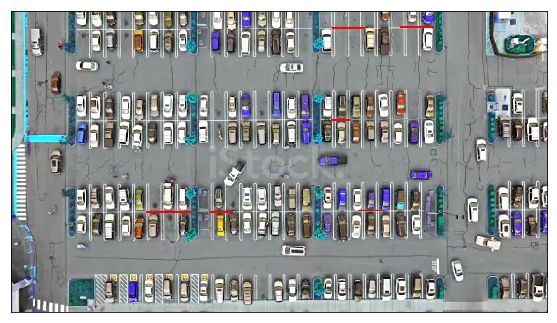

In [0]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    if make_copy:
        image = np.ascontiguousarray(np.copy(image), dtype=np.uint8)
    cleaned = []
    max_width  = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (abs(x2-x1) > 40):
                cleaned.append((x1,y1,x2,y2))
                cv2.line(image, (x1, y1), (x2, y2), color, thickness)

    print("MAX WIDTH: ", max_width)    
    print(" No lines detected: ", len(cleaned))
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(np.array(image), lines))
    print(image.dtype, image.shape)
show_images(line_images)

[[441 447 489 447]]
[[707 243 749 243]]
[[235  42 274  42]]


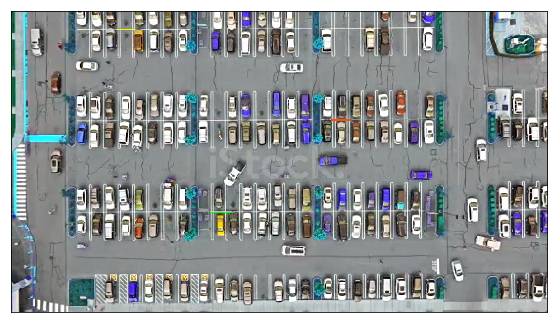

In [0]:
def extract_vertical_separators(lines, image):
    colors = [(0,255,0), (255,0,255), (0,76,255), (255,78,0), (238,255,0), (0,255,12),(255,0,0), (0,255,0), (255,0,255), (0,76,255), (255,78,0), (238,255,0), (0,255,12),(255,0,0)]
    image = np.ascontiguousarray(np.copy(image), dtype=np.uint8)
    index = 0
    middle_xs = []
    cv2.line(image, (0, 20), (0, 300), colors[index], 2)
    for line in lines:
      
      for x1,y1,x2,y2 in line:
          if (abs(x2-x1) > 30):
              append = True
              if middle_xs:
                for y_coordonate in middle_xs:
                    if abs(y_coordonate - y1) < 20:
                        append = False
                        break

              if append:
                middle_xs.append(y1)
                print(line)
                cv2.line(image, (x1, y1), (x2, y2), colors[index], 2)
              index += 1
    # show_images([image])
    return (middle_xs, image)


middle_lines = []
modified_line_images = []
for index, (image, lines) in enumerate(zip(test_images, list_of_lines)):
    x, img = extract_vertical_separators(lines, image)
    middle_lines.append(x)
    modified_line_images.append(img)
    # modified_line_images.append(draw_lines(np.array(image), middle_lines[index]))

show_images(modified_line_images)

In [0]:
def modified_hough_lines(lines, middles, image_shape):
    modified_lines = {}
  
    for x in middles:
        modified_lines[x] = []
    index = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            if (abs(x2-x1) ==0) and abs(y2-y1) > 30:
                for mid_y in middles:
                    if abs(mid_y - y1) < 60:
                      
                        if y2 <= mid_y:
                            modified_lines[mid_y].append([[x1, mid_y - 60,  x2,mid_y + 60]])
                        elif y1 >= mid_y:
                            modified_lines[mid_y].append([[x1, mid_y - 60,  x2, mid_y]])

                            if mid_y != image_shape[0]:
                                modified_lines[mid_y].append([[x1, mid_y - 60,  x2,mid_y + 60]])

                        else:

                            modified_lines[mid_y].append([[x1, mid_y - 60,  x2,mid_y + 60]])
                        index += 1
                        break

    return modified_lines
modified_lines = []
for lines, image, middle_line in zip(list_of_lines, test_images, middle_lines):
    modified_lines.append(modified_hough_lines(lines, middle_line, image.shape))

In [0]:
for index, (k, v) in enumerate(modified_lines[0].items()):
    print(v)
    break

[[[811, -18, 811, 102]], [[748, -18, 748, 102]], [[714, -18, 714, 102]], [[870, -18, 870, 102]], [[473, -18, 473, 102]], [[774, -18, 774, 102]], [[746, -18, 746, 102]], [[772, -18, 772, 102]], [[902, -18, 902, 102]], [[900, -18, 900, 102]], [[534, -18, 534, 102]], [[636, -18, 636, 102]], [[711, -18, 711, 102]], [[629, -18, 629, 102]], [[868, -18, 868, 102]], [[874, -18, 874, 42]], [[874, -18, 874, 102]], [[631, -18, 631, 102]], [[471, -18, 471, 102]], [[913, -18, 913, 102]], [[709, -18, 709, 102]], [[536, -18, 536, 102]], [[525, -18, 525, 42]], [[525, -18, 525, 102]], [[605, -18, 605, 102]], [[716, -18, 716, 102]]]


In [0]:
 def sort_lines(lines):   
    def bubbleSort(arr): 
        n = len(arr) 
      
        for i in range(n): 
      
            for j in range(0, n-i-1): 
      
                if arr[j][0][0] > arr[j+1][0][0] : 
                    arr[j], arr[j+1] = arr[j+1], arr[j] 
        
    bubbleSort(lines)

for mod_lines in modified_lines:
  for k, v in mod_lines.items():
      sort_lines(v)
    

In [0]:
for index, (k, v) in enumerate(modified_lines[0].items()):
    print(k)
    print(v)
    break

42
[[[471, -18, 471, 102]], [[473, -18, 473, 102]], [[525, -18, 525, 42]], [[525, -18, 525, 102]], [[534, -18, 534, 102]], [[536, -18, 536, 102]], [[605, -18, 605, 102]], [[629, -18, 629, 102]], [[631, -18, 631, 102]], [[636, -18, 636, 102]], [[709, -18, 709, 102]], [[711, -18, 711, 102]], [[714, -18, 714, 102]], [[716, -18, 716, 102]], [[746, -18, 746, 102]], [[748, -18, 748, 102]], [[772, -18, 772, 102]], [[774, -18, 774, 102]], [[811, -18, 811, 102]], [[868, -18, 868, 102]], [[870, -18, 870, 102]], [[874, -18, 874, 42]], [[874, -18, 874, 102]], [[900, -18, 900, 102]], [[902, -18, 902, 102]], [[913, -18, 913, 102]]]


('MAX WIDTH: ', 0)
(' No lines detected: ', 85)
(dtype('uint8'), (668, 1188, 3))


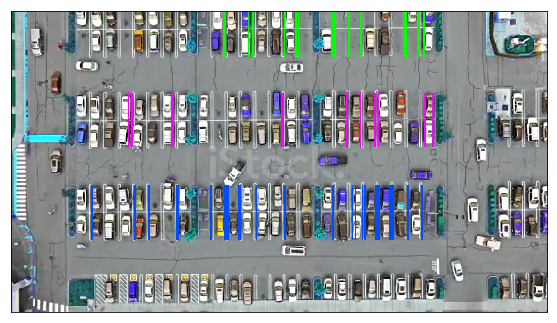

In [0]:
def draw_lines(image, line_clusters, color=[255, 0, 0], thickness=2, make_copy=True):
    colors = [(0,255,0), (255,0,255), (0,76,255), (255,78,0), (238,255,0), (0,255,12),(255,0,0)]
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.ascontiguousarray(np.copy(image), dtype=np.uint8) # don't want to modify the original
        # image = np.zeros(image.shape)
    cleaned = []
    max_width  = 0
    for index, (_, lines) in enumerate(line_clusters.items()):
      for line in lines:
          for x1,y1,x2,y2 in line:
              cleaned.append((x1,y1,x2,y2))
              cv2.line(image, (x1, y1), (x2, y2), colors[index], thickness)
    

    print("MAX WIDTH: ", max_width)    
    print(" No lines detected: ", len(cleaned))
    return image


line_images = []
for image, lines in zip(test_images, modified_lines):
    line_images.append(draw_lines(np.array(image), lines))
    print(image.dtype, image.shape)
show_images(line_images)

('MAX WIDTH: ', 0)
(' No lines detected: ', 30)


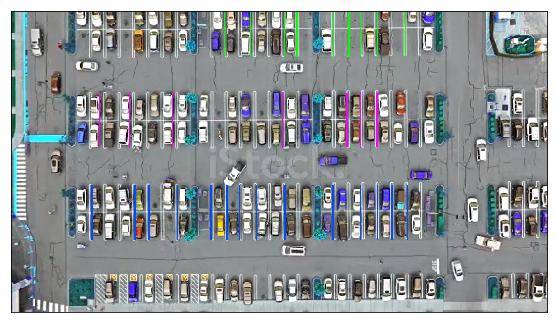

In [0]:
 def average_line_clusters(line_sections):
    final_dict = {}

    for index, (key, lines) in enumerate(line_sections.items()):
        averaged_lines = []
        not_last_line = True
        index = 0
        while not_last_line:
            nearest_neighbouring_lines = []
            nearest_neighbouring_lines.append(lines[index])
            
            while True:
                if (index + 1) < len(lines):
                    index +=1
                    
                    if abs(lines[index][0][0] - lines[index - 1][0][0]) <= 20:
                        nearest_neighbouring_lines.append(lines[index])
                    else:
                        avg_x = 0
                        avg_y1, avg_y2, = 0, 0
                        for line in nearest_neighbouring_lines:
                            for x1,y1,x2,y2 in line:
                                avg_x += x1
                                avg_y1, avg_y2, = y1, y2
                        avg_x = int(round(avg_x/len(nearest_neighbouring_lines)))
                        averaged_lines.append([[avg_x, avg_y1, avg_x, avg_y2]])
                        break
                else:
                    not_last_line = False
                    break
        final_dict[key] = averaged_lines
    return final_dict
            
averaged_lines = []
avg_lines_images = []

for index, (image, mod_lines) in enumerate(zip(test_images, modified_lines)):
    averaged_lines.append(average_line_clusters(mod_lines))
    avg_lines_images.append(draw_lines(np.array(image), averaged_lines[index]))
    break
show_images(avg_lines_images)

In [0]:
from collections import Counter

In [0]:
 def find_average_gap(line_sections):
    gaps = {}
    gaps_between_lines = []
    
    for index, (key, lines) in enumerate(line_sections.items()):
        # gaps_between_lines = []
        not_last_line = True
        index = 0
        while not_last_line:
            # gaps_between_lines = []
            # gaps_between_lines.append(lines[index])
            
            while True:
                if (index + 1) < len(lines):
                    index +=1

                    gaps_between_lines.append(abs(lines[index][0][0] - lines[index - 1][0][0]))
                    
                else:
                    not_last_line = False
                    break

        gaps[key] = gaps_between_lines
    print(Counter(gaps_between_lines))
    return max(Counter(gaps_between_lines).iteritems(), key=lambda x: x[1])[0] + 1
            
min_gap_lines = []
min_gap_images = []

for index, (image, avg_liness) in enumerate(zip(test_images, averaged_lines)):
    min_gap_lines.append(find_average_gap(averaged_lines[0]))

Counter({31: 2, 35: 2, 38: 2, 63: 2, 95: 2, 143: 1, 26: 1, 27: 1, 28: 1, 30: 1, 34: 1, 36: 1, 39: 1, 58: 1, 60: 1, 61: 1, 66: 1, 74: 1, 75: 1, 81: 1, 106: 1, 243: 1})


('MAX WIDTH: ', 0)
(' No lines detected: ', 2)


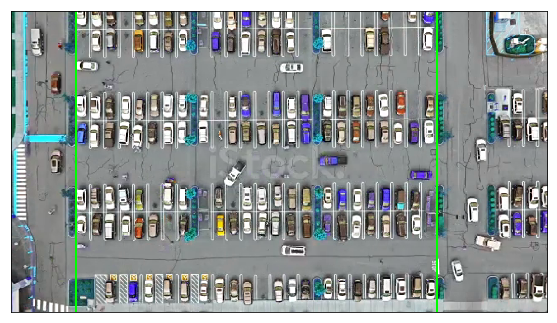

In [0]:
 def extract_x_boundaries(line_sections):
    biggest_x = []
    smallest_x = []
    gaps_between_lines = []
    x_max = 0
    x_min = test_images[0].shape[1]
    bias_max = 65
    bias_min= 36
    for index, (key, lines) in enumerate(line_sections.items()):
        # gaps_between_lines = []
        not_last_line = True
        index = 0
            
        while True:
            if index < len(lines):
                
                if lines[index][0][0] > x_max:
                    if biggest_x:
                        biggest_x[0] = [[lines[index][0][0] + bias_max,0,lines[index][0][2] + bias_max, test_images[0].shape[0] - 1]]
                    else:
                        biggest_x.append([[lines[index][0][0] + bias_max,0,lines[index][0][2] + bias_max, test_images[0].shape[0] - 1]])
                    x_max = lines[index][0][0]
                elif lines[index][0][0] < x_min:
                    if smallest_x:
                        smallest_x[0] = [[lines[index][0][0] - bias_min,0,lines[index][0][2] - bias_min, test_images[0].shape[0] - 1]]
                    else:
                        smallest_x.append([[lines[index][0][0] - bias_min,0,lines[index][0][2] - bias_min, test_images[0].shape[0] - 1]])
                    x_min = lines[index][0][0]

                index +=1    
            else:
                break

    return {0:[smallest_x[0], biggest_x[0]]}
            
x_boundaries = []
x_boundaries_images = []

for index, (image, avg_liness) in enumerate(zip(test_images, averaged_lines)):
    x_boundaries.append(extract_x_boundaries(averaged_lines[index]))
    # min_gap_lines.append(find_average_gap(avg_liness))
    x_boundaries_images.append(draw_lines(np.array(image), x_boundaries[index]))
   
show_images(x_boundaries_images)

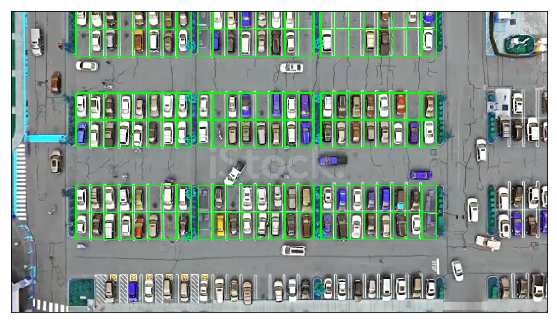

In [0]:
def define_parking_spots(avg_lines, boundaries, gap, image):
    parking_spots = {}
    x_boundaries = [boundary[0][0] for boundary in boundaries]

    new_image = np.ascontiguousarray(np.copy(image), dtype=np.uint8) # don't want to modify the original

    for index, (key, lines) in enumerate(avg_lines.items()):
        y_min, y_max = lines[0][0][1], lines[0][0][3]
        line_len = abs(y_max - y_min)/2
        rects = []
        x1 = x_boundaries[0]
        iteration = 0
        while x1 + gap <= x_boundaries[1] + 20:

            x1 = int(x1)
            x2 = int(x1 + gap)
            y1 = int(y_min)
            y2 = int(y_min + line_len)

            y2_1 = int(y_min + line_len)
            y2_2 = int(y2_1 + line_len)

            rects.append([x1, y1, x2, y2])
            rects.append([x1, y2_1, x2, y2_2])

            cv2.rectangle(new_image, (x1, y1),(x2,y2),(0,255,0),2)
            cv2.rectangle(new_image, (x1, y2_1),(x2,y2_2),(0,255,0),2)


            if iteration < 7:
                x1 = x1 + gap
                iteration += 1
            else:
                x1 = x1 + gap + 15
                iteration = 0

        parking_spots[index] = rects

    return (parking_spots, new_image)

parking_map = []
parking_map_images = []

for index, (image, avg_liness) in enumerate(zip(test_images, averaged_lines)):
    
    parking_rects, img = define_parking_spots(avg_liness, x_boundaries[index][0], min_gap_lines[index], image)
    parking_map.append(parking_rects)
    parking_map_images.append(img)
   
show_images(parking_map_images)

In [0]:
parking_map[0][0]

[[143, -18, 175, 42],
 [143, 42, 175, 102],
 [175, -18, 207, 42],
 [175, 42, 207, 102],
 [207, -18, 239, 42],
 [207, 42, 239, 102],
 [239, -18, 271, 42],
 [239, 42, 271, 102],
 [271, -18, 303, 42],
 [271, 42, 303, 102],
 [303, -18, 335, 42],
 [303, 42, 335, 102],
 [335, -18, 367, 42],
 [335, 42, 367, 102],
 [367, -18, 399, 42],
 [367, 42, 399, 102],
 [414, -18, 446, 42],
 [414, 42, 446, 102],
 [446, -18, 478, 42],
 [446, 42, 478, 102],
 [478, -18, 510, 42],
 [478, 42, 510, 102],
 [510, -18, 542, 42],
 [510, 42, 542, 102],
 [542, -18, 574, 42],
 [542, 42, 574, 102],
 [574, -18, 606, 42],
 [574, 42, 606, 102],
 [606, -18, 638, 42],
 [606, 42, 638, 102],
 [638, -18, 670, 42],
 [638, 42, 670, 102],
 [685, -18, 717, 42],
 [685, 42, 717, 102],
 [717, -18, 749, 42],
 [717, 42, 749, 102],
 [749, -18, 781, 42],
 [749, 42, 781, 102],
 [781, -18, 813, 42],
 [781, 42, 813, 102],
 [813, -18, 845, 42],
 [813, 42, 845, 102],
 [845, -18, 877, 42],
 [845, 42, 877, 102],
 [877, -18, 909, 42],
 [877, 42,

In [0]:
len(parking_map[0][2])

48

In [0]:
 def sort_lines_ids(lines):   
    def bubbleSort(arr): 
        n = len(arr) 
      
        for i in range(n): 
      
            for j in range(0, n-i-1): 
      
                if arr[j][1] > arr[j+1][1] : 
                    arr[j], arr[j+1] = arr[j+1], arr[j] 
        
    bubbleSort(lines)

def assign_parking_ids(parking_map):
    parking_id = {}

    for index, (key, rects) in enumerate(parking_map.items()):
        sort_lines_ids(rects)
        parkings = {}
        for i, rect in enumerate(rects):
            id = str(index) + '-' + str(i)
            parkings[id] = rect
        parking_id[key] = parkings

    return parking_id


parking_spot_with_id = []
for p_map in parking_map:
    parking_spot_with_id.append(assign_parking_ids(p_map))

In [0]:
parking_spot_with_id

[{0: {'0-0': [143, -18, 175, 42],
   '0-1': [175, -18, 207, 42],
   '0-10': [478, -18, 510, 42],
   '0-11': [510, -18, 542, 42],
   '0-12': [542, -18, 574, 42],
   '0-13': [574, -18, 606, 42],
   '0-14': [606, -18, 638, 42],
   '0-15': [638, -18, 670, 42],
   '0-16': [685, -18, 717, 42],
   '0-17': [717, -18, 749, 42],
   '0-18': [749, -18, 781, 42],
   '0-19': [781, -18, 813, 42],
   '0-2': [207, -18, 239, 42],
   '0-20': [813, -18, 845, 42],
   '0-21': [845, -18, 877, 42],
   '0-22': [877, -18, 909, 42],
   '0-23': [909, -18, 941, 42],
   '0-24': [143, 42, 175, 102],
   '0-25': [175, 42, 207, 102],
   '0-26': [207, 42, 239, 102],
   '0-27': [239, 42, 271, 102],
   '0-28': [271, 42, 303, 102],
   '0-29': [303, 42, 335, 102],
   '0-3': [239, -18, 271, 42],
   '0-30': [335, 42, 367, 102],
   '0-31': [367, 42, 399, 102],
   '0-32': [414, 42, 446, 102],
   '0-33': [446, 42, 478, 102],
   '0-34': [478, 42, 510, 102],
   '0-35': [510, 42, 542, 102],
   '0-36': [542, 42, 574, 102],
   '0-37'

In [0]:
len(parking_map)

1

##Average detection

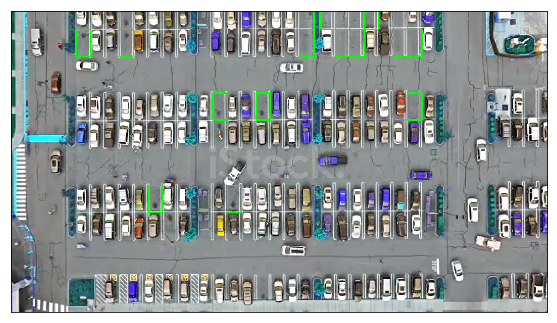

In [0]:
imageArr = []
imageArr = np.array(image2)
def _average_detector(parking_spot_with_id):
      for key,lots in parking_spot_with_id.items():
        for index, (parking_id,parking_rect) in enumerate(lots.items()):
            grayCounter = 0
            padding = 8
            # for each lot, define a gray counter to count the gray(ish) pixels in the lot
            # and a padding to focus on the center of the lot
            for x in range(parking_rect[0]+padding, parking_rect[2]-padding):
              for y in range(parking_rect[1]+padding, parking_rect[3]-padding):
                # get rgb from images
                r,g,b = imageArr[y][x][0],imageArr[y][x][1],imageArr[y][x][2]
                # calculate diff from colors (to find gray)
                r = int(r)
                g = int(g)
                b = int(b)
                diffRG = abs(r-g)
                diffGB = abs(g-b)
                diffBR = abs(b-r)
                diffSum = diffRG + diffGB + diffBR
                # if the difference between all r,g,b is less than a threshold (30) 
                # and 255 >r > 0 (to prevent white and black from being detected)
                if(diffSum < 30 and r > 30 and r < 225):
                  # to see which spots are detected as "grayish" uncomment the line below
                  # imageArr[y][x] = [0,0,255]
                  grayCounter += 1
            # take the parking lot size in pixels minus the padding
            pSize = (parking_rect[2]-parking_rect[0]- 2*padding)*(parking_rect[3]-parking_rect[1]- 2*padding)
            # find percent gray pixels inside the lot by dividing gray counter with lot size
            percentGray = grayCounter/pSize
            # if the percent of gray in the lot is greater than a threshold, then we have an empty lot
            if percentGray > 0.93:
              cv2.rectangle(imageArr, (parking_rect[0],parking_rect[1]),(parking_rect[2],parking_rect[3]),(0,255,0),2)
_average_detector(parking_spot_with_id[0])     

imgesss = []
imgesss.append(imageArr)
show_images(imgesss)

##Corner detection

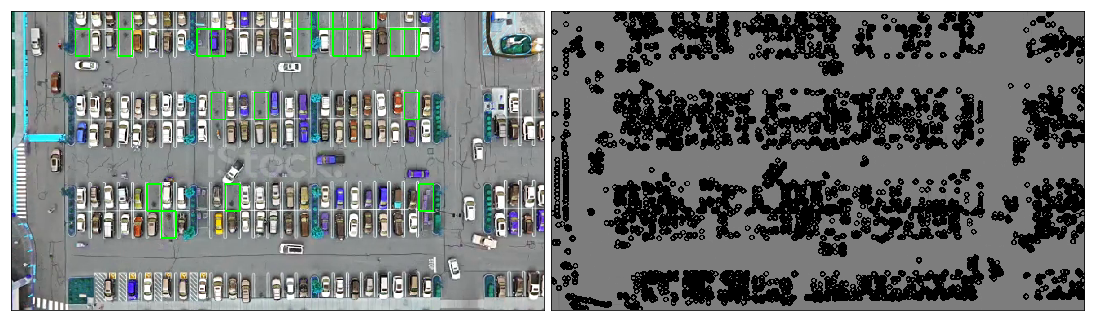

In [0]:
#using corner detector to find parking spot
# imageArr2 = []

def _corner_detector(parking_spot_with_id):
    src_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    imageArr2 = np.array(image2)
    imgesss2 = []

    # Detector parameters
    blockSize = 2
    apertureSize = 3
    k = 0.04
    thresh = 83

    #using Harris corner detector
    dst = cv2.cornerHarris(src_gray, blockSize, apertureSize, k)

    # Normalizing
    dst_norm = np.empty(dst.shape, dtype=np.float32)
    cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    dst_norm_scaled = cv2.convertScaleAbs(dst_norm)

    for key,lots in parking_spot_with_id.items():
        for index, (parking_id,parking_rect) in enumerate(lots.items()):
            numberOfCornor = 0
            for x in range(parking_rect[0]+4, parking_rect[2]-4):
                for y in range(parking_rect[1]+4, parking_rect[3]-4):
                  if int(dst_norm[y,x]) > thresh:
                      numberOfCornor += 1
            if numberOfCornor <= 3:
                cv2.rectangle(imageArr2, (parking_rect[0],parking_rect[1]),(parking_rect[2],parking_rect[3]),(0,255,0),2)

    return imageArr2
                  

# imgesss2.append(imageArr2)
corner_images = []
imageArr3 = np.array(dst_norm_scaled)
for map_id in parking_spot_with_id:
    corner_images.append(_corner_detector(map_id))
# print(imgesss2)
corner_images.append(imageArr3)
show_images(corner_images)

In [0]:
parking_rects[0]

[[143, -18, 175, 42],
 [175, -18, 207, 42],
 [207, -18, 239, 42],
 [239, -18, 271, 42],
 [271, -18, 303, 42],
 [303, -18, 335, 42],
 [335, -18, 367, 42],
 [367, -18, 399, 42],
 [414, -18, 446, 42],
 [446, -18, 478, 42],
 [478, -18, 510, 42],
 [510, -18, 542, 42],
 [542, -18, 574, 42],
 [574, -18, 606, 42],
 [606, -18, 638, 42],
 [638, -18, 670, 42],
 [685, -18, 717, 42],
 [717, -18, 749, 42],
 [749, -18, 781, 42],
 [781, -18, 813, 42],
 [813, -18, 845, 42],
 [845, -18, 877, 42],
 [877, -18, 909, 42],
 [909, -18, 941, 42],
 [143, 42, 175, 102],
 [175, 42, 207, 102],
 [207, 42, 239, 102],
 [239, 42, 271, 102],
 [271, 42, 303, 102],
 [303, 42, 335, 102],
 [335, 42, 367, 102],
 [367, 42, 399, 102],
 [414, 42, 446, 102],
 [446, 42, 478, 102],
 [478, 42, 510, 102],
 [510, 42, 542, 102],
 [542, 42, 574, 102],
 [574, 42, 606, 102],
 [606, 42, 638, 102],
 [638, 42, 670, 102],
 [685, 42, 717, 102],
 [717, 42, 749, 102],
 [749, 42, 781, 102],
 [781, 42, 813, 102],
 [813, 42, 845, 102],
 [845, 42,

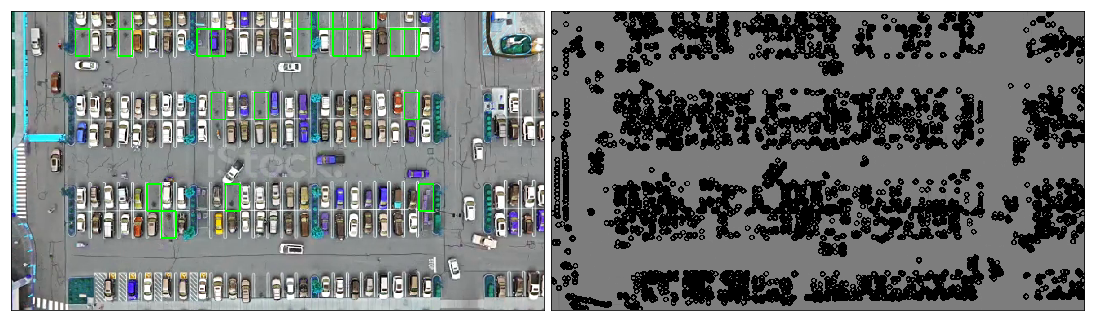

In [0]:
# #using corner detector to find parking spot
# imageArr2 = []

# src_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
# imageArr2 = np.array(image2)
# imgesss2 = []

# # Detector parameters
# blockSize = 2
# apertureSize = 3
# k = 0.04
# thresh = 83

# #using Harris corner detector
# dst = cv2.cornerHarris(src_gray, blockSize, apertureSize, k)

# # Normalizing
# dst_norm = np.empty(dst.shape, dtype=np.float32)
# cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# dst_norm_scaled = cv2.convertScaleAbs(dst_norm)


# for i in range(dst_norm.shape[0]):
#         for j in range(dst_norm.shape[1]):
#             if int(dst_norm[i,j]) > thresh:
#                 cv2.circle(dst_norm_scaled, (j,i), 5, (0), 2)



# for i in range(len(parking_rects)):
#   for index, parking_rect in enumerate(parking_rects[i]):
#       numberOfCornor = 0
#       for x in range(parking_rect[0]+4, parking_rect[2]-4):
#         for y in range(parking_rect[1]+4, parking_rect[3]-4):
#           if int(dst_norm[y,x]) > thresh:
#                 numberOfCornor += 1
#       if numberOfCornor <= 3:
#         cv2.rectangle(imageArr2, (parking_rect[0],parking_rect[1]),(parking_rect[2],parking_rect[3]),(0,255,0),2)
                  

# imgesss2.append(imageArr2)
# imageArr3 = np.array(dst_norm_scaled)
# imgesss2.append(imageArr3)

# show_images(imgesss2)

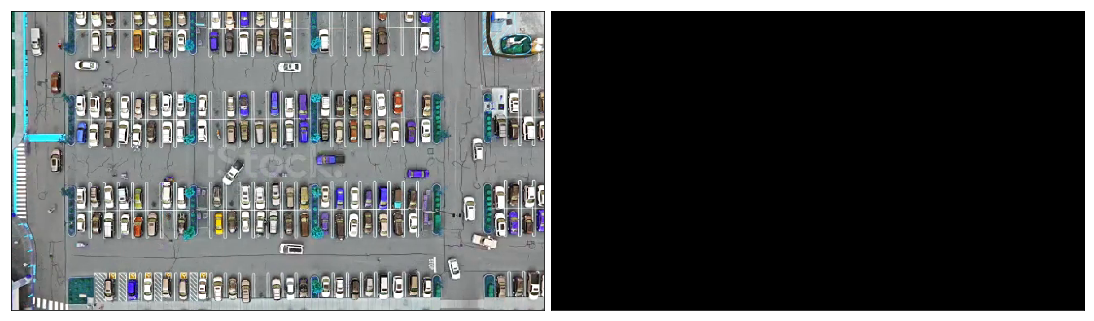

In [0]:
# #using corner detector to find parking spot
# imageArr2 = []

# src_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# imageArr2 = np.array(image)
# imgesss2 = []

# # Detector parameters
# blockSize = 2
# apertureSize = 3
# k = 0.04
# thresh = 69

# #using Harris corner detector
# dst = cv2.cornerHarris(src_gray, blockSize, apertureSize, k)

# # Normalizing
# dst_norm = np.empty(dst.shape, dtype=np.float32)
# cv2.normalize(dst, dst_norm, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# dst_norm_scaled = cv2.convertScaleAbs(dst_norm)


# for i in range(dst_norm.shape[0]):
#         for j in range(dst_norm.shape[1]):
#             if int(dst_norm[i,j]) > thresh:
#                 cv2.circle(dst_norm_scaled, (j,i), 5, (0), 2)

# for i in range(len(parking_rects)):
#   for index, parking_rect in enumerate(parking_rects[i]):
#       numberOfCornor = 0
#       for x in range(parking_rect[0]+4, parking_rect[2]-4):
#         for y in range(parking_rect[1]+4, parking_rect[3]-4):
#           if int(dst_norm[y,x]) > thresh:
#                 numberOfCornor += 1
#       if numberOfCornor <= 9:
#         cv2.rectangle(imageArr2, (parking_rect[0],parking_rect[1]),(parking_rect[2],parking_rect[3]),(0,255,0),2)
                  

# imgesss2.append(imageArr2)
# imageArr3 = np.array(dst_norm_scaled)
# imgesss2.append(imageArr3)

# show_images(imgesss2)

##Save objects

In [0]:
import pickle

final_map = parking_spot_with_id

pickle_out = open("parking_map_with_id_final.pickle","wb")
pickle.dump(final_map, pickle_out)
pickle_out.close()

IOError: ignored

In [0]:
pickle_in = open("parking_map_with_id_final.pickle","rb")
loaded_dict = pickle.load(pickle_in)

IOError: ignored

In [0]:
loaded_dict

In [0]:
parking_rects